In [ ]:
# Temporaxis Battery Motif Chain Analysis
*Clean Notebook for Publication/Peer Review*

**Author:** Carney Pryately  
**Notebook:** Temp_Battery_MotifChain_Final.ipynb  
**Date:** 2025-06-26

---
> This notebook demonstrates the open research version of Temporaxis, reproducing results in Shea (2025).  
> Proprietary scoring kernels and commercial modules are NOT included here.  
> For commercial licensing, contact the author.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 120)


In [3]:
# Load battery cycle/capacity data and clean non-numeric values

df = pd.read_csv('all_discharge_capacities.csv')

# Ensure capacity is numeric (coerce errors, drop NaNs)
df['capacity'] = pd.to_numeric(df['capacity'], errors='coerce')
df = df.dropna(subset=['capacity'])

print("Data loaded. Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Unique battery files:", df['file'].nunique())
df.head()


Data loaded. Shape: (2769, 3)
Columns: ['file', 'cycle_index', 'capacity']
Unique battery files: 34


,file,cycle_index,capacity
0,B0005.mat,2,1.856487
1,B0005.mat,4,1.846327
2,B0005.mat,6,1.835349
3,B0005.mat,8,1.835263
4,B0005.mat,10,1.834646


In [4]:
def detect_motifs(capacity, window=10, delta_thresh=0.015, flat_thresh=0.002, osc_thresh=0.008):
    """
    Detects motifs in a 1D numpy array of capacity values.
    Returns a list of motif labels (same length as input minus 2*window).
    Δ: Sudden drop, ⇅: Oscillation, ∗: Flat/null, .: No motif
    """
    motifs = []
    for i in range(window, len(capacity)-window):
        w = capacity[i-window:i+window+1]
        # Δ: Sudden drop
        if capacity[i-1] - capacity[i] > delta_thresh:
            motifs.append('Δ')
        # ⇅: Oscillation
        elif np.std(w) > osc_thresh and (capacity[i] - capacity[i-1]) * (capacity[i-1] - capacity[i-2]) < 0:
            motifs.append('⇅')
        # ∗: Flat/null
        elif np.std(w) < flat_thresh:
            motifs.append('∗')
        else:
            motifs.append('.')
    return motifs


In [5]:
# Detect motif chains across all batteries and build a results table

results = []

for file in df['file'].unique():
    batt_df = df[df['file'] == file].sort_values('cycle_index').reset_index(drop=True)
    batt_df['capacity'] = batt_df['capacity'].astype(float)
    motifs = detect_motifs(
        batt_df['capacity'].values,
        delta_thresh=0.015,
        flat_thresh=0.002,
        osc_thresh=0.008
    )
    batt_df = batt_df.iloc[10:len(batt_df)-10].copy()
    batt_df['motif'] = motifs

    motif_str = ''.join(batt_df['motif'].values)
    chain_pattern = '⇅Δ'  # Motif chain pattern for collapse (oscillation → drop)
    collapse_chain_indices = [i+1 for i in range(len(motif_str)-1) if motif_str[i:i+2] == chain_pattern]
    collapse_chain_cycles = batt_df['cycle_index'].iloc[collapse_chain_indices].tolist()

    results.append({
        'file': file,
        'n_cycles': len(batt_df),
        'n_motifs': motifs.count('Δ') + motifs.count('⇅') + motifs.count('∗'),
        'n_chains': len(collapse_chain_cycles),
        'chain_cycles': collapse_chain_cycles
    })

results_df = pd.DataFrame(results)
display(results_df.sort_values('n_chains', ascending=False).reset_index(drop=True))


,file,n_cycles,n_motifs,n_chains,chain_cycles
0,B0033.mat,177,112,17,"[31, 59, 85, 99, 117, 131, 145, 159, 299, 335,..."
1,B0056.mat,82,61,16,"[33, 63, 75, 93, 97, 141, 147, 153, 159, 165, ..."
2,B0055.mat,82,59,15,"[29, 33, 83, 87, 93, 99, 141, 147, 153, 159, 1..."
3,B0034.mat,177,118,12,"[57, 99, 117, 131, 159, 325, 389, 407, 417, 43..."
4,B0054.mat,83,65,12,"[35, 57, 77, 99, 113, 117, 151, 163, 181, 191,..."
5,B0018.mat,112,47,9,"[68, 104, 121, 130, 143, 181, 214, 225, 296]"
6,B0053.mat,36,29,7,"[31, 43, 59, 71, 75, 81, 95]"
7,B0047.mat,52,28,6,"[39, 55, 65, 79, 127, 133]"
8,B0048.mat,52,28,5,"[55, 65, 79, 127, 131]"
9,B0030.mat,20,12,4,"[28, 42, 52, 64]"


Temporaxis wins (chain < threshold): 10 out of 34 batteries
Average cycles lead (positive = Temporaxis earlier): 67.5
Median cycles lead: 48.0


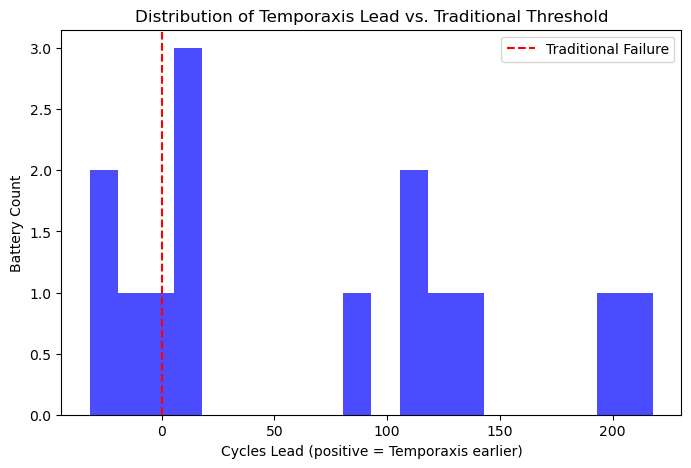

In [6]:
# Compare motif chain detection (Temporaxis) to traditional 80% failure threshold

# Step 1: Compute traditional failure (first cycle where capacity < 80% of initial) for each battery
traditional_thresholds = {}
for file in df['file'].unique():
    batt_df = df[df['file'] == file].sort_values('cycle_index').reset_index(drop=True)
    batt_df['capacity'] = batt_df['capacity'].astype(float)
    if len(batt_df) == 0:
        continue
    cap0 = batt_df['capacity'].iloc[0]
    fail_idx = batt_df[batt_df['capacity'] < 0.8 * cap0]
    if not fail_idx.empty:
        traditional_thresholds[file] = fail_idx['cycle_index'].iloc[0]
    else:
        traditional_thresholds[file] = None  # Never crosses threshold

# Step 2: Count and compare wins, compute lead time (cycles early/late)
win_count = 0
deltas = []

for idx, row in results_df.iterrows():
    file = row['file']
    chain_cycles = row['chain_cycles']
    trad_cycle = traditional_thresholds.get(file)
    if chain_cycles and trad_cycle:
        earliest_chain = min(chain_cycles)
        cycles_early = trad_cycle - earliest_chain
        deltas.append(cycles_early)
        if earliest_chain < trad_cycle:
            win_count += 1

print(f"Temporaxis wins (chain < threshold): {win_count} out of {len(results_df)} batteries")
if deltas:
    print("Average cycles lead (positive = Temporaxis earlier):", np.mean([d for d in deltas if d is not None]))
    print("Median cycles lead:", np.median([d for d in deltas if d is not None]))
else:
    print("No overlaps found for lead computation.")

plt.figure(figsize=(8,5))
plt.hist([d for d in deltas if d is not None], bins=20, color='blue', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label='Traditional Failure')
plt.xlabel('Cycles Lead (positive = Temporaxis earlier)')
plt.ylabel('Battery Count')
plt.title('Distribution of Temporaxis Lead vs. Traditional Threshold')
plt.legend()
plt.show()


In [10]:
import os

# Create a new folder called 'plots' if it doesn't exist
os.makedirs('plots', exist_ok=True)

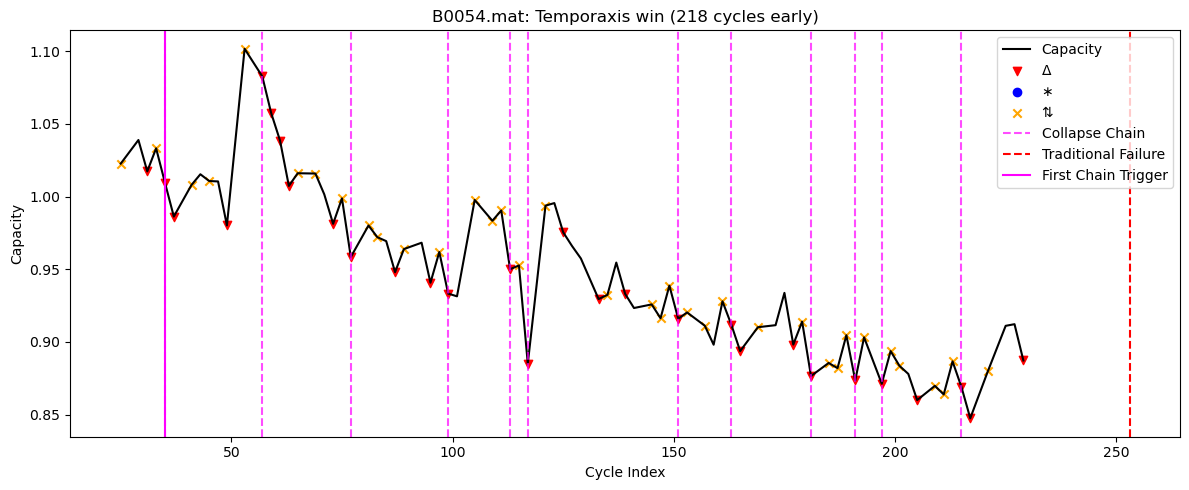

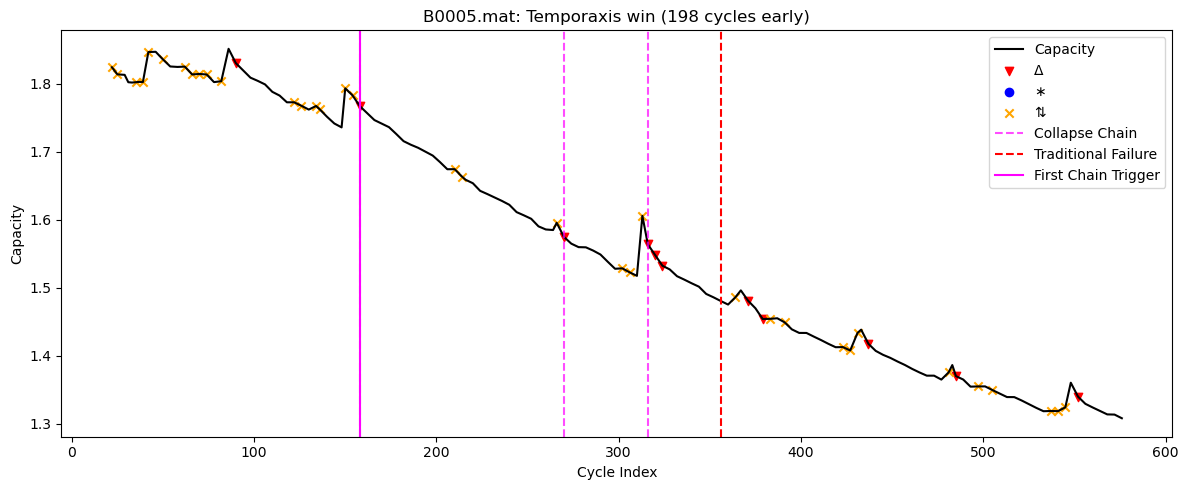

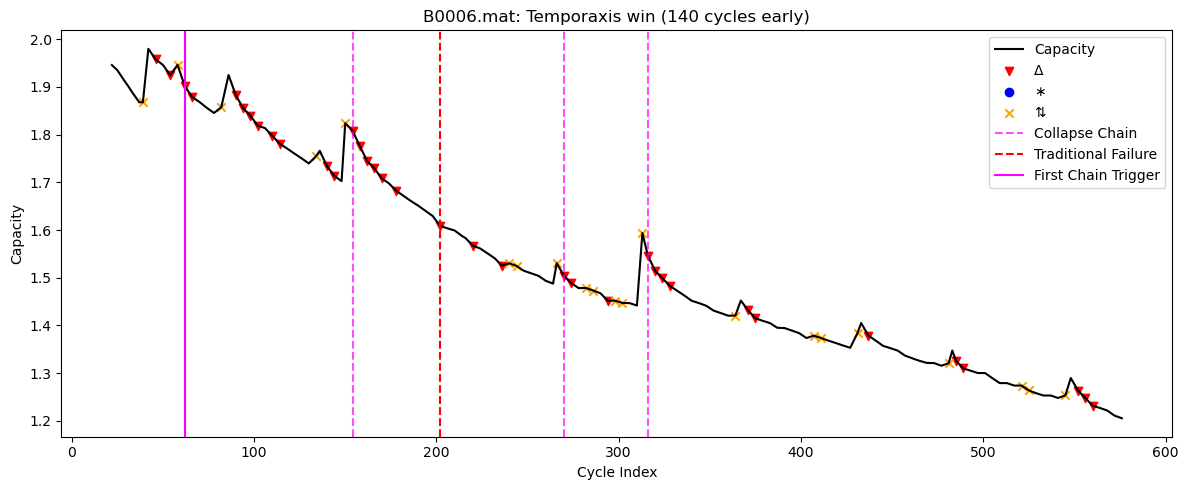

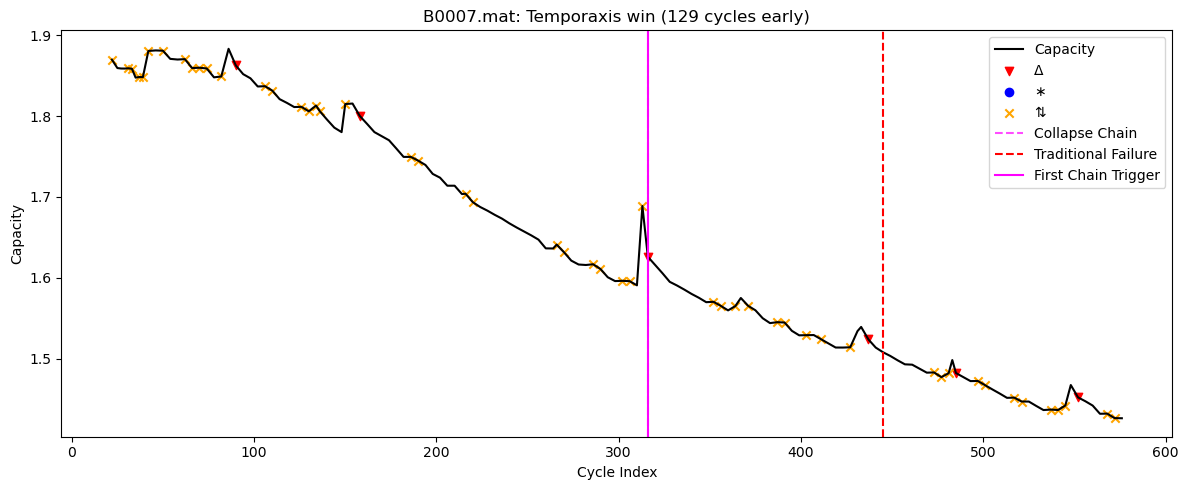

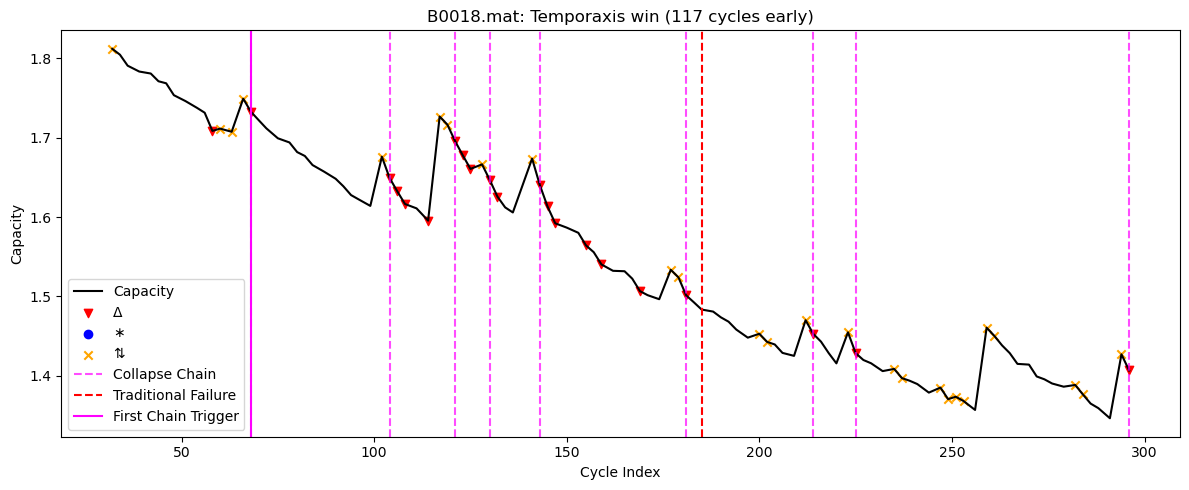

In [14]:
# Plot and save the top N Temporaxis wins to the 'plots' folder

N = 5  # Number of top wins to save

for idx, row in case_studies_df.head(N).iterrows():
    sample_file = row['file']
    batt_df = df[df['file'] == sample_file].sort_values('cycle_index').reset_index(drop=True)
    batt_df['capacity'] = batt_df['capacity'].astype(float)
    motifs = detect_motifs(
        batt_df['capacity'].values,
        delta_thresh=0.015,
        flat_thresh=0.002,
        osc_thresh=0.008
    )
    batt_df = batt_df.iloc[10:len(batt_df)-10].copy()
    batt_df['motif'] = motifs

    motif_str = ''.join(batt_df['motif'].values)
    chain_pattern = '⇅Δ'
    collapse_chain_indices = [i+1 for i in range(len(motif_str)-1) if motif_str[i:i+2] == chain_pattern]

    plt.figure(figsize=(12,5))
    plt.plot(batt_df['cycle_index'], batt_df['capacity'], label='Capacity', color='black')
    for motif, color, marker in [('Δ', 'red', 'v'), ('∗', 'blue', 'o'), ('⇅', 'orange', 'x')]:
        motif_locs = batt_df[batt_df['motif'] == motif]
        plt.scatter(motif_locs['cycle_index'], motif_locs['capacity'], color=color, marker=marker, label=motif)
    for cidx in collapse_chain_indices:
        plt.axvline(batt_df['cycle_index'].iloc[cidx], color='magenta', linestyle='--', alpha=0.7, label='Collapse Chain' if cidx == collapse_chain_indices[0] else "")
    plt.axvline(row['traditional_failure'], color='red', linestyle='--', label='Traditional Failure')
    plt.axvline(row['earliest_chain'], color='magenta', linestyle='-', label='First Chain Trigger')
    plt.xlabel('Cycle Index')
    plt.ylabel('Capacity')
    plt.title(f'{sample_file}: Temporaxis win ({row["cycles_early"]} cycles early)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'plots/{sample_file}_temporaxis_win.png', dpi=300)   # <-- Save to plots folder
    plt.show()


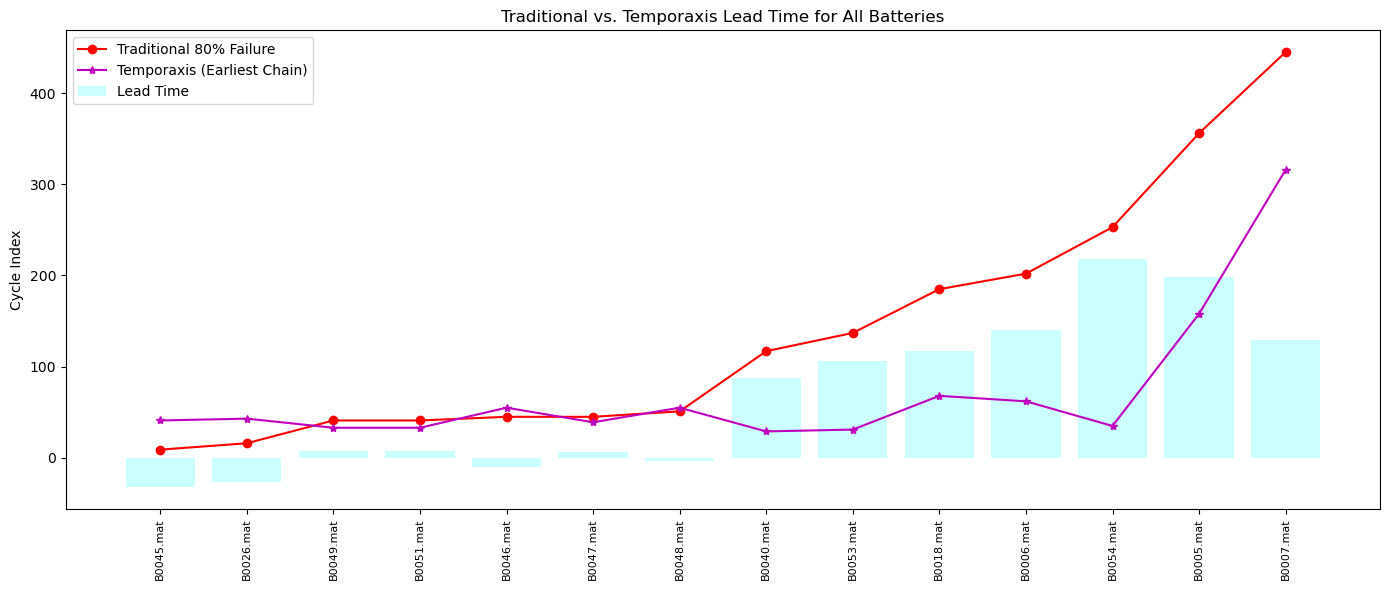

In [15]:
import numpy as np

# Prepare data for plotting
plot_batteries = []
trad_cycles = []
temp_cycles = []
lead_times = []

for idx, row in results_df.iterrows():
    file = row['file']
    trad = traditional_thresholds.get(file)
    chains = row['chain_cycles']
    if trad and chains:
        plot_batteries.append(file)
        trad_cycles.append(trad)
        temp_cycles.append(min(chains))
        lead_times.append(trad - min(chains))

# Sort by traditional failure cycle
sort_idx = np.argsort(trad_cycles)
plot_batteries = np.array(plot_batteries)[sort_idx]
trad_cycles = np.array(trad_cycles)[sort_idx]
temp_cycles = np.array(temp_cycles)[sort_idx]
lead_times = np.array(lead_times)[sort_idx]

plt.figure(figsize=(14,6))
plt.plot(trad_cycles, 'ro-', label='Traditional 80% Failure')
plt.plot(temp_cycles, 'm*-', label='Temporaxis (Earliest Chain)')
plt.bar(np.arange(len(lead_times)), lead_times, alpha=0.2, color='cyan', label='Lead Time')
plt.xticks(range(len(plot_batteries)), plot_batteries, rotation=90, fontsize=8)
plt.ylabel('Cycle Index')
plt.title('Traditional vs. Temporaxis Lead Time for All Batteries')
plt.legend()
plt.tight_layout()
plt.savefig('plots/temporaxis_vs_traditional_all_batteries.png', dpi=300)
plt.show()
